In [74]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv("data.csv")

## --- Missing values initially ---

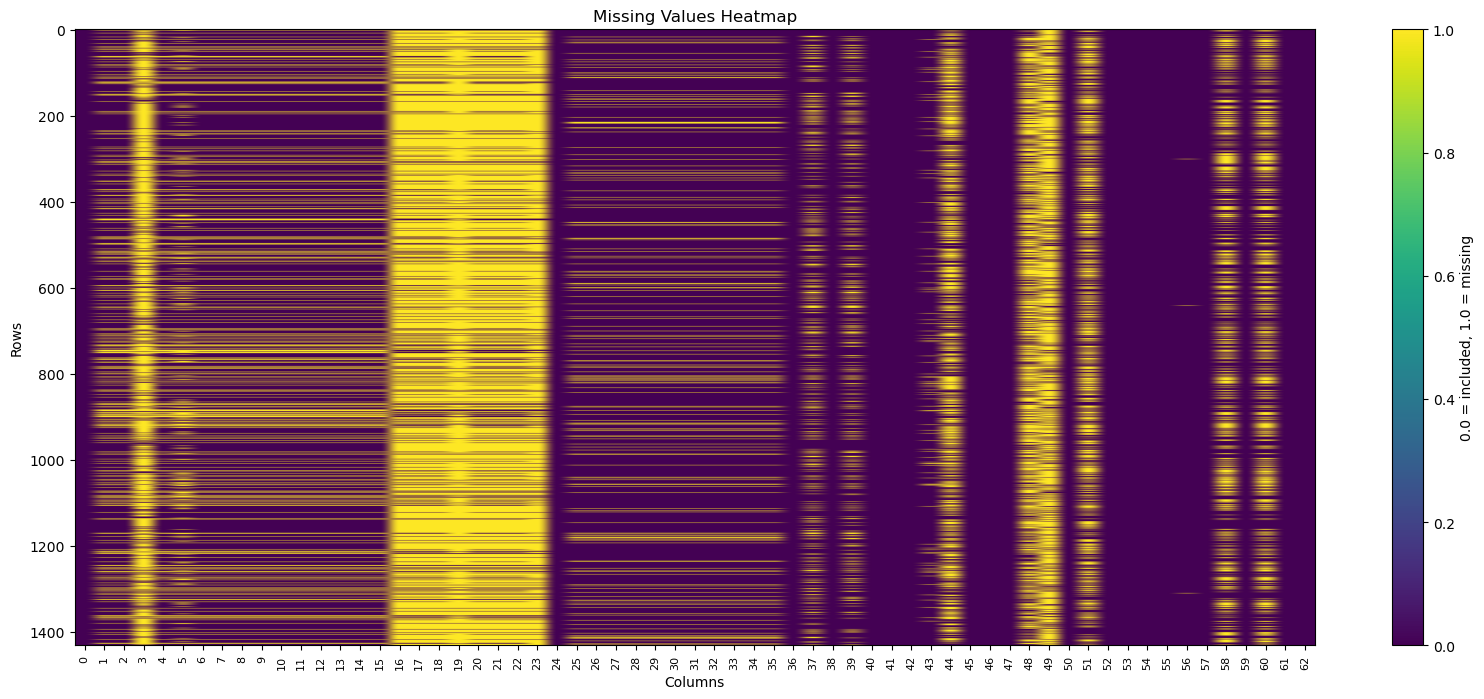

In [75]:
plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

## --- Deleting all open questions ---

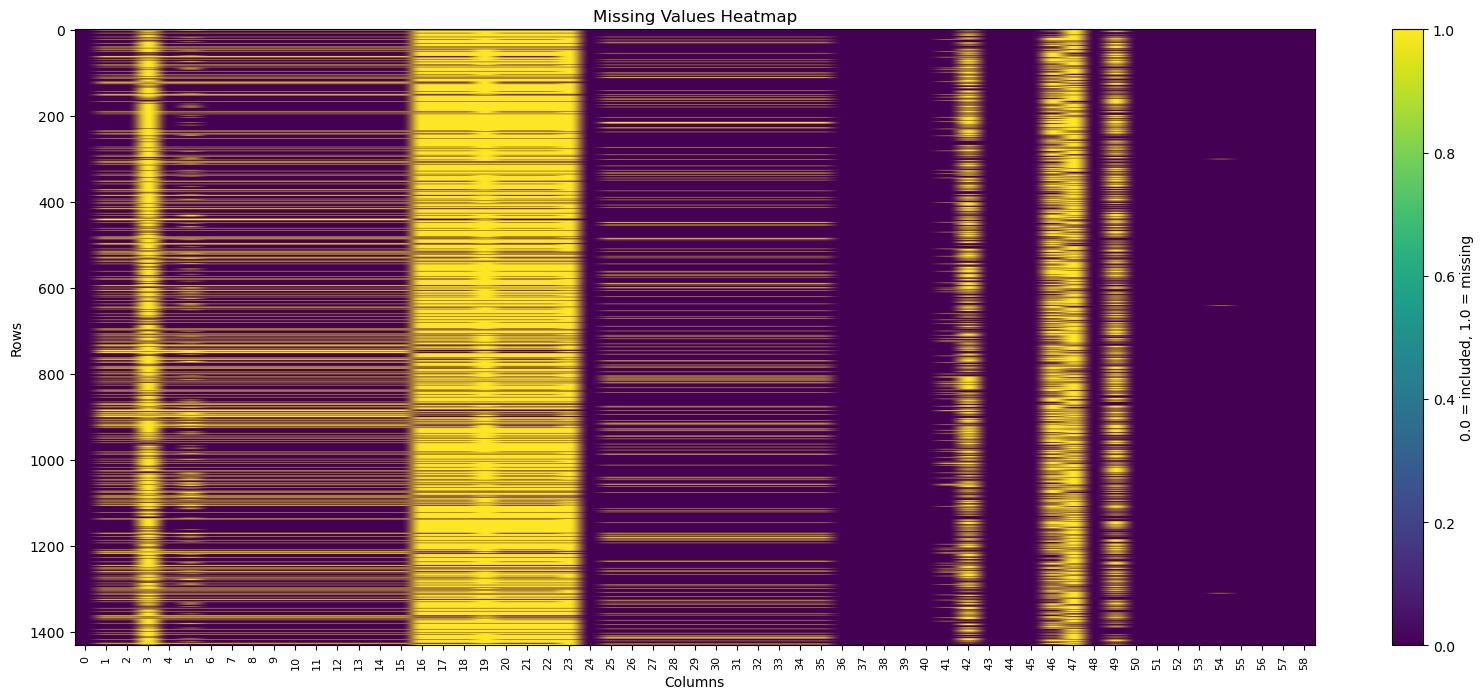

In [76]:
data_clean = data.drop(columns=["Why or why not?", "Why or why not?.1", 'What US state or territory do you live in?', 'What US state or territory do you work in?'])

plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data_clean.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data_clean.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

## --- Deleting Questioned with a missing ratio > 40% ---

In [77]:
# calculate missing ratio
data_clean['missing_ratio'] = data_clean.isna().mean(axis=1)
# Consider only those Questioned with a missing ratio higher than 40%
bad_rows = data_clean[data_clean['missing_ratio'] > 0.4]

# out of all columns get only the id, missing_count and missing_ratio
cols = [data_clean.columns[0]] + list(data_clean.columns[-2:])
# sort the values descending
bad_rows.sort_values("missing_ratio", ascending=False)[cols]

,Are you self-employed?,Do you work remotely?,missing_ratio
808,1,Sometimes,0.559322
511,1,Sometimes,0.559322
877,1,Sometimes,0.542373
340,1,Sometimes,0.542373
739,1,Sometimes,0.542373
...,...,...,...
346,0,Never,0.406780
934,0,Always,0.406780
655,0,Sometimes,0.406780
947,0,Sometimes,0.406780


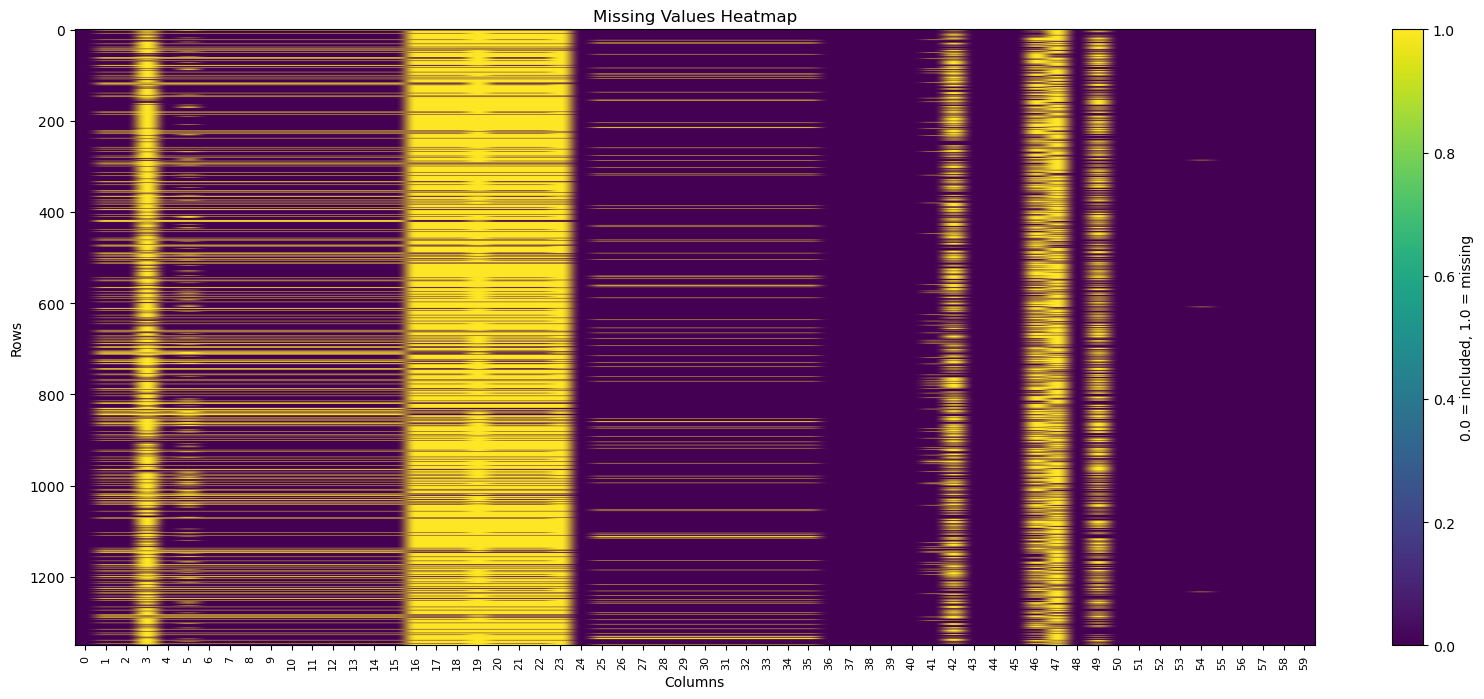

In [78]:
# delete those rows
data_clean = data_clean.drop(bad_rows.index).reset_index(drop=True)

plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data_clean.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data_clean.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

## --- Deleting Questions with a missing ratio > 40% ---

In [79]:
# find questions with missing ratio > 40%
bad_cols = data_clean.isna().mean()
bad_cols = bad_cols[bad_cols > 0.4].sort_values(ascending=False)
bad_cols.index

Index(['If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
       'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
       'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?',
       'Do you know local or online resources to seek help for a mental health disorder?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
       'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
       'Do you believe your productivity is ever affected by a mental health issue?',
       'Is your primary 

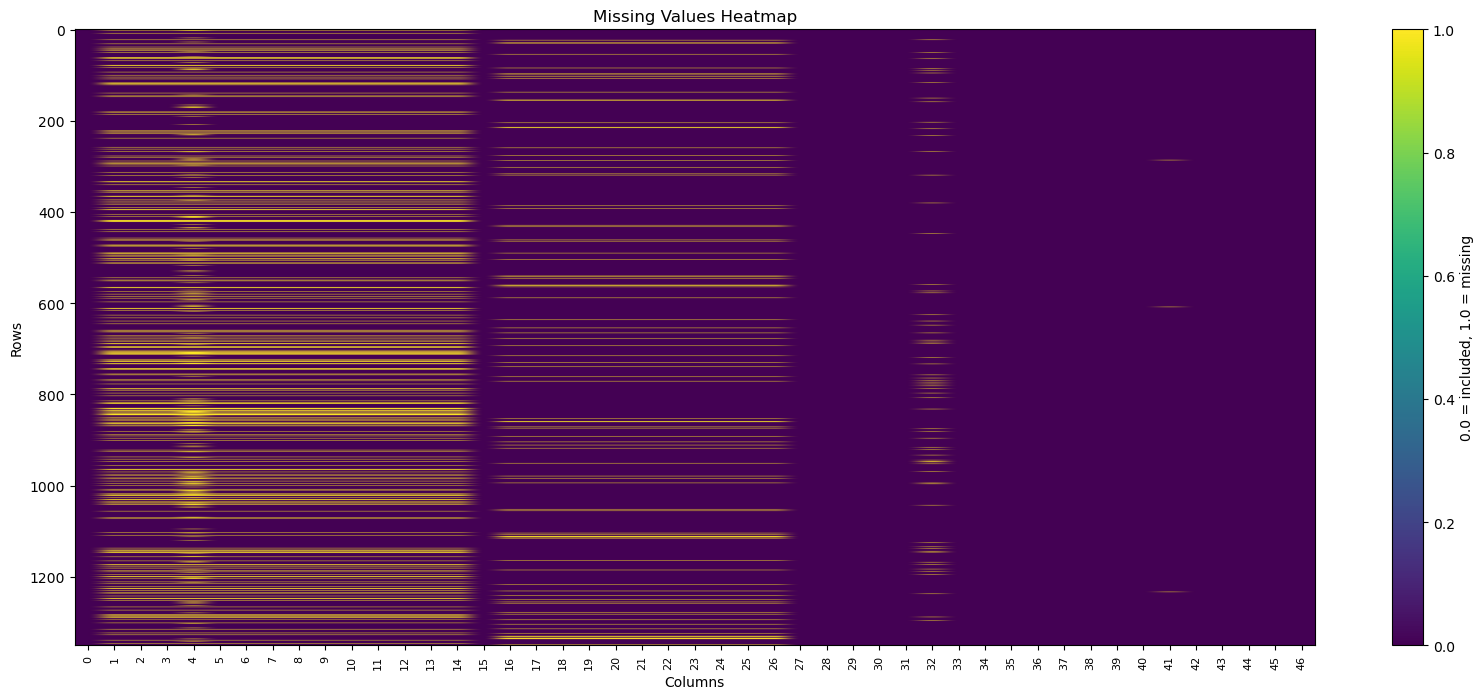

In [80]:
# remove "\xa0" from data_clean question
data_clean.columns = data_clean.columns.str.replace('\xa0', ' ').str.strip()
# remove "\xa0" from bad_cols question
bad_cols = [col.replace('\xa0', ' ').strip() for col in bad_cols.index]
# delete
cols_to_drop = [col for col in bad_cols if col in data_clean.columns]
data_clean = data_clean.drop(columns=cols_to_drop)

plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data_clean.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data_clean.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

## --- Imputation for all Questioned with missing ratio <25% (Part 1: Unifying answers)---

In [81]:
### SHOW ONLY QUESTIONS THAT HAVE AT LEAST ONE MISSING ANSWER

# Consider only questions with less than 25% missing ratio
data_clean = data_clean[data_clean["missing_ratio"] < 0.25]

# total answers amount
max_rows = len(data_clean)

for i, col in enumerate(data_clean.columns):

    non_null = data_clean[col].notna().sum()
    nulls = data_clean[col].isna().sum()

    # show only columns that contain missing values
    if nulls > 0:
        print(f"[{i}] Column: {col}")
        
        # value counts excluding NaN
        print(data_clean[col].value_counts(dropna=True))
        print("-" * 40)
        
        print(f"Answered:     {non_null}/{max_rows}")
        print(f"Not answered: {nulls}/{max_rows}")
        print("=" * 40)


[4] Column: Do you know the options for mental health care available under your employer-provided coverage?
Do you know the options for mental health care available under your employer-provided coverage?
No               311
I am not sure    308
Yes              279
Name: count, dtype: int64
----------------------------------------
Answered:     898/1014
Not answered: 116/1014
[32] Column: Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
No                    414
Maybe/Not sure        252
Yes, I observed       184
Yes, I experienced    126
Name: count, dtype: int64
----------------------------------------
Answered:     976/1014
Not answered: 38/1014
[41] Column: What is your gender?
What is your gender?
Male                                                      

In [82]:
### Overwrite different values to Man, Woman or Other
import re
def map_gender(x):
    # if null, return null
    if pd.isna(x):
        return pd.NA
    
    s = str(x).strip().lower()

    # === male patterns ===
    male_keywords = [
        r"\bmale\b", r"\bm\b", r"\bman\b", r"cis[- ]?male",
        r"cis[- ]?man", r"male\.?", r"sex is male"
    ]
    
    # === female patterns ===
    female_keywords = [
        r"\bfemale\b", r"\bf\b", r"\bwoman\b", r"cis[- ]?female",
        r"cis[- ]?woman", r"female\.?"
    ]

    # check male
    for kw in male_keywords:
        if re.search(kw, s):
            return "Man"

    # check female
    for kw in female_keywords:
        if re.search(kw, s):
            return "Woman"

    # everything else → other
    return "Other"

data_clean['What is your gender?'] = data_clean['What is your gender?'].apply(map_gender)

In [83]:
### SHOW ONLY QUESTIONS THAT HAVE AT LEAST ONE MISSING ANSWER (Now with corrected genders)
max_rows = len(data_clean)

for i, col in enumerate(data_clean.columns):

    non_null = data_clean[col].notna().sum()
    nulls = data_clean[col].isna().sum()

    if nulls > 0:
        print(f"[{i}] Column: {col}")
        
        print(data_clean[col].value_counts(dropna=True))
        print("-" * 40)
        
        print(f"Answered:     {non_null}/{max_rows}")
        print(f"Not answered: {nulls}/{max_rows}")
        print("=" * 40)



[4] Column: Do you know the options for mental health care available under your employer-provided coverage?
Do you know the options for mental health care available under your employer-provided coverage?
No               311
I am not sure    308
Yes              279
Name: count, dtype: int64
----------------------------------------
Answered:     898/1014
Not answered: 116/1014
[32] Column: Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
No                    414
Maybe/Not sure        252
Yes, I observed       184
Yes, I experienced    126
Name: count, dtype: int64
----------------------------------------
Answered:     976/1014
Not answered: 38/1014
[41] Column: What is your gender?
What is your gender?
Man      944
Woman     44
Other     23
Name: count, dtype:

## --- Imputation for all Questioned with missing ratio <25% (Part 2: Imputation)---

In [84]:
data_clean[data_clean.columns[4]] = data_clean[data_clean.columns[4]].fillna("I am not sure")
data_clean[data_clean.columns[32]] = data_clean[data_clean.columns[32]].fillna("Maybe/Not sure")
data_clean[data_clean.columns[41]] = data_clean[data_clean.columns[41]].fillna("Other")

# calculate missing_ratio again
data_clean['missing_ratio'] = data_clean.isna().mean(axis=1)

## --- Unifying all other answers ---

In [85]:
### SHOW ALL QUESTIONS (to see what answers need to be unified)
max_rows = len(data_clean)

for i, col in enumerate(data_clean.columns):

    non_null = data_clean[col].notna().sum()
    nulls = data_clean[col].isna().sum()

    print(f"[{i}] Column: {col}")
        
    print(data_clean[col].value_counts(dropna=True))
    print("-" * 40)
        
    print(f"Answered:     {non_null}/{max_rows}")
    print(f"Not answered: {nulls}/{max_rows}")
    print("=" * 40)

[0] Column: Are you self-employed?
Are you self-employed?
0    1014
Name: count, dtype: int64
----------------------------------------
Answered:     1014/1014
Not answered: 0/1014
[1] Column: How many employees does your company or organization have?
How many employees does your company or organization have?
26-100            260
100-500           228
More than 1000    218
6-25              184
500-1000           73
1-5                51
Name: count, dtype: int64
----------------------------------------
Answered:     1014/1014
Not answered: 0/1014
[2] Column: Is your employer primarily a tech company/organization?
Is your employer primarily a tech company/organization?
1.0    787
0.0    227
Name: count, dtype: int64
----------------------------------------
Answered:     1014/1014
Not answered: 0/1014
[3] Column: Does your employer provide mental health benefits as part of healthcare coverage?
Does your employer provide mental health benefits as part of healthcare coverage?
Yes         

In [86]:
### Delete AGE-outliers (<17 and >67)
data_clean = data_clean[(data_clean['What is your age?'] >= 17) & (data_clean['What is your age?'] <= 67)]

### Create bins for AGE
bins = [16, 25, 35, 45, 55, 67]
labels = ['17-25', '26-35', '36-45', '46-55', '56-67']
data_clean['What is your age?'] = pd.cut(data_clean['What is your age?'], bins=bins, labels=labels, include_lowest=True)

In [87]:
### Let only top 10 countries, the rest goes to "Others"
top_n = 10  
# living countries
top_live = data_clean['What country do you live in?'].value_counts().nlargest(top_n).index
data_clean['What country do you live in?'] = data_clean['What country do you live in?'].apply(lambda x: x if x in top_live else 'Other')
# working countries
top_work = data_clean['What country do you work in?'].value_counts().nlargest(top_n).index
data_clean['What country do you work in?'] = data_clean['What country do you work in?'].apply(lambda x: x if x in top_work else 'Other')

In [88]:
### Map roles
role_map = {
    "supervisor": "Management / Lead",
    "team lead": "Management / Lead",
    "executive": "Management / Lead",
    "lead": "Management / Lead",
    "manager": "Management / Lead",

    "back-end": "Developer",
    "front-end": "Developer",
    "full-stack": "Developer",
    "full stack": "Developer",
    "developer": "Developer",
    "engineer": "Developer",
    "qa": "Developer",
    "test": "Developer",

    "devops": "DevOps",
    "sysadmin": "DevOps",
    "it ops": "DevOps",
    "sre": "DevOps",
    "support": "DevOps",

    "designer": "Product Design",
    "design": "Product Design",
    "ui": "Product Design",
    "ux": "Product Design",

    "data": "Data & Analytics",
    "ml": "Data & Analytics",
    "analyst": "Data & Analytics",

    "hr": "HR / Admin",
    "administration": "HR / Admin",
    "admin": "HR / Admin",

    "evangelist": "Community",
    "advocate": "Community",
    "writer": "Community",
}

# set priorities if a person has more than one role
priority = {
    "Management / Lead": 1,
    "Developer": 2,
    "DevOps": 3,
    "Product Design": 4,
    "Data & Analytics": 5,
    "HR / Admin": 6,
    "Community": 7,
    "Other": 99
}

def classify_role(text):
    roles = str(text).lower().split("|")

    found_categories = []

    for role in roles:
        matched = False
        for keyword, cat in role_map.items():
            if keyword in role:
                found_categories.append(cat)
                matched = True
                break
        if not matched:
            found_categories.append("Other")

    # choose role with highest priority
    found_categories = sorted(found_categories, key=lambda x: priority[x])
    return found_categories[0]

# overwrite
data_clean["Which of the following best describes your work position?"] = data_clean["Which of the following best describes your work position?"].apply(classify_role)


### Delete missing_ratio column
del data_clean["missing_ratio"]

In [89]:
### SHOW MAPPED ANSWERS
max_rows = len(data_clean)
for i, col in enumerate(data_clean.columns):

    non_null = data_clean[col].notna().sum()
    nulls = data_clean[col].isna().sum()

    print(f"[{i}] Column: {col}")
        
    print(data_clean[col].value_counts(dropna=True))
    print("-" * 40)
        
    print(f"Answered:     {non_null}/{max_rows}")
    print(f"Not answered: {nulls}/{max_rows}")
    print("=" * 40)

[0] Column: Are you self-employed?
Are you self-employed?
0    1009
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[1] Column: How many employees does your company or organization have?
How many employees does your company or organization have?
26-100            259
100-500           226
More than 1000    217
6-25              183
500-1000           73
1-5                51
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[2] Column: Is your employer primarily a tech company/organization?
Is your employer primarily a tech company/organization?
1.0    783
0.0    226
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[3] Column: Does your employer provide mental health benefits as part of healthcare coverage?
Does your employer provide mental health benefits as part of healthcare coverage?
Yes         

## --- Encoding all answers into numerical values ---

In [90]:
### binary and categorial-nominal data

from sklearn.preprocessing import OneHotEncoder
one_hot_cols = data_clean.columns[[0,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,41,42,43,44]].tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
ohe_transform = ohe.fit_transform(data_clean[one_hot_cols])

ohe_transform

,Are you self-employed?_0,Is your employer primarily a tech company/organization?_0.0,Is your employer primarily a tech company/organization?_1.0,Does your employer provide mental health benefits as part of healthcare coverage?_I don't know,Does your employer provide mental health benefits as part of healthcare coverage?_No,Does your employer provide mental health benefits as part of healthcare coverage?_Not eligible for coverage / N/A,Does your employer provide mental health benefits as part of healthcare coverage?_Yes,Do you know the options for mental health care available under your employer-provided coverage?_I am not sure,Do you know the options for mental health care available under your employer-provided coverage?_No,Do you know the options for mental health care available under your employer-provided coverage?_Yes,...,What country do you work in?_Sweden,What country do you work in?_United Kingdom,What country do you work in?_United States of America,Which of the following best describes your work position?_Community,Which of the following best describes your work position?_DevOps,Which of the following best describes your work position?_Developer,Which of the following best describes your work position?_HR / Admin,Which of the following best describes your work position?_Management / Lead,Which of the following best describes your work position?_Other,Which of the following best describes your work position?_Product Design
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1345,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1346,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1348,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [91]:
### categorial-ordinal data
import joblib
from sklearn.preprocessing import OrdinalEncoder

ordinal_cols = data_clean.columns[[1,8,31,38,39,40,45]].tolist()

encoder = OrdinalEncoder(categories=[
    ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"],   # How many employees does your company or organization have?
    ["Very difficult", "Somewhat difficult", "Neither easy nor difficult", "Somewhat easy", "Very easy", "I don't know"],             # If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
    ["Not open at all", "Somewhat not open", "Neutral", "Somewhat open", "Very open", "Not applicable to me (I do not have a mental illness)"],     # How willing would you be to share with friends and family that you have a mental illness?
    ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"] ,    # If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
    ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"],     # If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
    ["17-25", "26-35", "36-45", "46-55", "56-67"],     # What is your age?
    ["Never", "Sometimes", "Always"]    # Do you work remotely?
])

data_clean[ordinal_cols] = encoder.fit_transform(data_clean[ordinal_cols])
# save to decode it later in 3_training.ipynb
joblib.dump(encoder, 'ordinal_encoder.pkl')

data_clean

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,...,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What country do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,2.0,1.0,Not eligible for coverage / N/A,I am not sure,No,No,I don't know,4.0,No,...,Yes,0,4.0,4.0,2.0,Man,United Kingdom,United Kingdom,Developer,1.0
1,0,1.0,1.0,No,Yes,Yes,Yes,Yes,3.0,No,...,Yes,1,1.0,2.0,1.0,Man,United States of America,United States of America,Developer,0.0
2,0,1.0,1.0,No,I am not sure,No,No,I don't know,2.0,Maybe,...,No,1,4.0,4.0,2.0,Man,United Kingdom,United Kingdom,Developer,2.0
4,0,1.0,0.0,Yes,Yes,No,No,No,2.0,Yes,...,Yes,1,2.0,2.0,2.0,Man,United States of America,United States of America,Management / Lead,1.0
5,0,5.0,1.0,Yes,I am not sure,No,Yes,Yes,3.0,Yes,...,No,1,4.0,3.0,2.0,Man,United Kingdom,United Kingdom,Developer,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0,3.0,1.0,Yes,I am not sure,Yes,Yes,Yes,3.0,No,...,No,0,1.0,1.0,0.0,Man,Canada,Canada,Management / Lead,1.0
1345,0,3.0,1.0,I don't know,I am not sure,No,I don't know,I don't know,3.0,Maybe,...,Yes,1,1.0,3.0,1.0,Man,Canada,Canada,Other,1.0
1346,0,4.0,1.0,Yes,No,No,No,Yes,3.0,No,...,Yes,1,1.0,3.0,2.0,Man,United States of America,United States of America,DevOps,2.0
1348,0,3.0,1.0,Yes,Yes,Yes,Yes,I don't know,1.0,Maybe,...,Yes,1,1.0,2.0,3.0,Man,United States of America,United States of America,Developer,1.0


## --- Creating new DataFrame with one-hot-encoded values and ordinal-encoded values ---

In [92]:
### create new DataFrame with encoded-only values
data_encoded = pd.concat([ohe_transform, data_clean[ordinal_cols]], axis=1)

In [93]:
### show encoded answers
max_rows = len(data_encoded)
for i, col in enumerate(data_encoded.columns):

    non_null = data_encoded[col].notna().sum()
    nulls = data_encoded[col].isna().sum()

    print(f"[{i}] Column: {col}")
        
    print(data_encoded[col].value_counts(dropna=True))
    print("-" * 40)
        
    print(f"Answered:     {non_null}/{max_rows}")
    print(f"Not answered: {nulls}/{max_rows}")
    print("=" * 40)

[0] Column: Are you self-employed?_0
Are you self-employed?_0
1.0    1009
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[1] Column: Is your employer primarily a tech company/organization?_0.0
Is your employer primarily a tech company/organization?_0.0
0.0    783
1.0    226
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[2] Column: Is your employer primarily a tech company/organization?_1.0
Is your employer primarily a tech company/organization?_1.0
1.0    783
0.0    226
Name: count, dtype: int64
----------------------------------------
Answered:     1009/1009
Not answered: 0/1009
[3] Column: Does your employer provide mental health benefits as part of healthcare coverage?_I don't know
Does your employer provide mental health benefits as part of healthcare coverage?_I don't know
0.0    726
1.0    283
Name: count, dtype: int64
--------------------------------

## --- Scaling all answers ---

In [94]:
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
### scale the whole dataframe
#data_scaled = pd.DataFrame(
#    scaler.fit_transform(data_encoded),
#    columns=data_encoded.columns
#)
#
### show encoded answers
#max_rows = len(data_scaled)
#for i, col in enumerate(data_scaled.columns):
#
#    non_null = data_scaled[col].notna().sum()
#    nulls = data_scaled[col].isna().sum()
#
#    print(f"[{i}] Column: {col}")
#       
#    print(data_scaled[col].value_counts(dropna=True))
#    print("-" * 40)
#        
#    print(f"Answered:     {non_null}/{max_rows}")
#    print(f"Not answered: {nulls}/{max_rows}")
#    print("=" * 40)


In [95]:
data_scaled.to_csv('data_preprocessed.csv', index=False)